# yt-spam-comments

Using machine learning to fight crypto-spam on YouTube!

## Preparations
Importing libraries, debug information, ...

In [63]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline
from sklearn.model_selection import train_test_split

In [64]:
print("Version: ", tf.__version__)

Version:  2.5.0


### Option 1: Load dataset from local file

In [95]:
csv = pd.read_csv(
    "../02-rated-comments/rated-comments.csv",
    delimiter=";"
)

# DataFrame with only "Comment" and "Spam" columns
df = csv[["Comment", "Spam"]]

# Remove all comments that have no ratings
df = df.dropna()

# Show what we got
df

,Comment,Spam
211,Savjeeeeeee💩💩,0.0
238,Thanks! Really appreciate your kind words!,0.0
250,When you create a new container in Docker you ...,0.0
255,"+tony davies (tgrrr) No, Bitbucket Pipelines i...",0.0
256,I guess that would be possible yes. But why wo...,0.0
...,...,...
15549,Scammer,0.0
15564,SO proof of work the power is on big miners.\n...,0.0
15565,Perfectly explained. The miracle of simplicity...,0.0
15566,Nicely explained,0.0


### Option 2: Load dataset from Google Sheets

In [133]:
import gspread

gc = gspread.service_account(filename= "../04-inference/yt-spam-filter-013e7aa5ffc1.json")
sh = gc.open_by_key("1QEQrLne1SDxwQVl5qpGQokEKG4FNZqX6kMuFMmAyeWg")
worksheet = sh.get_worksheet(0)

df = pd.DataFrame(worksheet.get_all_records())
df = df[["Comment", "Spam"]]

# Make sure that comments are parsed as strings
df['Comment'] = df['Comment'].astype(str)

# Remove all comments that have no ratings
nan_value = float("NaN")

df = df.replace("", nan_value).dropna().drop_duplicates()

df

,Comment,Spam
211,Savjeeeeeee💩💩,0.0
238,Thanks! Really appreciate your kind words!,0.0
250,When you create a new container in Docker you ...,0.0
255,"+tony davies (tgrrr) No, Bitbucket Pipelines i...",0.0
256,I guess that would be possible yes. But why wo...,0.0
...,...,...
15671,I APPRECIATE THE GOOD WORK *DANTECHIES* ON INS...,1.0
15675,I'mma give best shout öut to *Doavercracks* 🇱🇷...,1.0
15677,Thanks Goodness i was able to meet *Doavercrac...,1.0
15687,Nobody does it better than *DANTECHIES* He's a...,1.0


Checking how many spam/not spam comments we have in the dataset.

<AxesSubplot:xlabel='Spam', ylabel='count'>

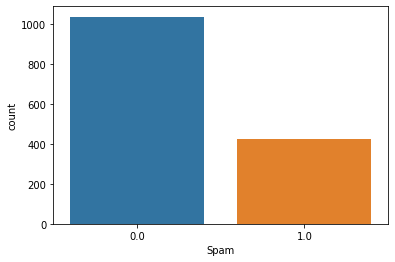

In [134]:
sns.countplot(x="Spam",data=df)

## Split data set into training & validation

In [67]:
# helps in text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# helps in model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping

# split data into train and test set
from sklearn.model_selection import train_test_split

In [135]:
X = df['Comment'].values
y = df['Spam'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    
print(len(X_train))
print(len(X_test))

1168
293


## Building the model

In [69]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 50)                48190600  
_________________________________________________________________
dense_6 (Dense)              (None, 16)                816       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [137]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# fit the model
model.fit(X_train,
         y_train,
         epochs=40,
         batch_size=512,
         validation_data=(X_test, y_test),
         verbose=1,
         callbacks=[early_stop]
)

Epoch 1/40
3/3 [==============================] - 1s 361ms/step - loss: 0.5236 - accuracy: 0.8271 - val_loss: 0.5216 - val_accuracy: 0.7826
Epoch 2/40
3/3 [==============================] - 1s 320ms/step - loss: 0.4832 - accuracy: 0.8510 - val_loss: 0.4969 - val_accuracy: 0.7942
Epoch 3/40
3/3 [==============================] - 1s 316ms/step - loss: 0.4544 - accuracy: 0.8741 - val_loss: 0.4755 - val_accuracy: 0.8116
Epoch 4/40
3/3 [==============================] - 1s 320ms/step - loss: 0.4297 - accuracy: 0.8921 - val_loss: 0.4563 - val_accuracy: 0.8261
Epoch 5/40
3/3 [==============================] - 1s 318ms/step - loss: 0.4072 - accuracy: 0.9110 - val_loss: 0.4370 - val_accuracy: 0.8406
Epoch 6/40
3/3 [==============================] - 1s 329ms/step - loss: 0.3861 - accuracy: 0.9212 - val_loss: 0.4187 - val_accuracy: 0.8957
Epoch 7/40
3/3 [==============================] - 1s 331ms/step - loss: 0.3664 - accuracy: 0.9281 - val_loss: 0.4016 - val_accuracy: 0.9072
Epoch 8/40
3/3 [====

## Save model to disk
This will later be used in the AWS Lambda backend to periodically fetch comments & mark them as spam

In [139]:
model.save("trained-model.h5")
model.save("../04-inference/trained-model.h5")

## Test

In [138]:
sms = [
    # Seen before
    "That's nice, thanks for replying, you can send a message to my administrator on watsap to earn in crypto especially Bitcoin ...+\u202a..1..6.1..3..6.0..4..5..7..4..7 He's excellent at what he does, tell him referred you to him. His passionate strategies are top notch the ✌️🇺🇸",
    
    # New spam
    "I’m so happy I met RM_KESH01 on Insta he help me recover my lost Erc20 sent to a wrong network I’m so happy because his trusted and reliable"
    "This is wonderful and unbelievable just got my Bitcoin account back through Doavercracks on ig thanks a lot really appreciate it.",
    "I recommend y’all to Doavercracks on IG.",
    "BTC price to volatiles swing, making it historically popular for traders to speculate on. According to bitcoin having cycles, there should be at least other four months in this bull run, so, if the Pi indicator (and bitcoin) might repeat a similar bull run to 2013,that would mean a local top relatively close in time and then another top to end the bull run towards mid year, investor's and trader's find it difficult to decide how best to utilize the current market, holding is profitable but trading is far more profitable, I was able to grasp knowledge of trading crypto assets earlier enough, I didn't think it was possible to make constant win from trading till I come across Mrs milly program for investor's and newbies who lack understanding on how trading BTC works, to help them stack up more bitcoin, since late last year till date I have made over 19BTC from 2.6BTC with Mrs milly's help, you can easily get to her with this WhatsApp number +1-2-1-0-8-0-6-4-8-8-9",
    "Never thought it was possible to recover my lost btc until I meet victoolz on insta who helped me...",
    "Can’t recommend him enough for his tireless effort and tremendous job done Doavercracks on IG his truly the best 💯💯",
    "𝟰𝗕𝗧𝗖 𝘄𝗮𝘀 𝘀𝗲𝗻𝘁 𝘁𝗼 𝗺𝘆 𝗯𝗹𝗼𝗰𝗸𝗰𝗵𝗮𝗶𝗻 𝗮𝗰𝗰𝗼𝘂𝗻𝘁 𝗜'𝗺 𝘁𝗵𝗮𝗻𝗸𝗶𝗻𝗴 𝗚𝗼𝗱  𝗳𝗼𝗿 𝘀𝗲𝗻𝗱𝗶𝗻𝗴 𝗜𝗢𝗦𝗧𝗢𝗢𝗟𝗦 𝗼𝗻 !𝗚 𝗳𝗼𝗿 𝘀𝗮𝘃𝗶𝗻𝗴 𝗺𝘆 𝗹𝗶𝗳𝗲",
    "Another 0.05682 bitcoin was recover by this Dude *DANTECHIES* on instagram, I appreciate the work he did for me..",
    "😭😢😭😭 *core_cyber* on Instagram just made me proud, thank you so much sir..",
    
    # Not spam
    "Amazing video!",
    "Maybe to make proof of stake system more democraric we can think about share a certain amount of money the validator get to all the other validators?",
    "I don’t get it 😅😂",
    "Watching this video as El Salvador 🇸🇻 just made bitcoin a legal tender..lol",
    
    # Made up spam (definitely not seen before)
    "Xavier is wonderful, I traded with him and made huge profits",
    "Contact Mr. Decuyper on msgnr for advice"

]

for test in sms:
    out = model.predict([test])
    print("%s - %f - %s" % ("Spam" if out[0] > 0.5 else "HAM", out[0], test))
    print()


Spam - 0.999907 - That's nice, thanks for replying, you can send a message to my administrator on watsap to earn in crypto especially Bitcoin ...+‪..1..6.1..3..6.0..4..5..7..4..7 He's excellent at what he does, tell him referred you to him. His passionate strategies are top notch the ✌️🇺🇸

Spam - 0.999906 - I’m so happy I met RM_KESH01 on Insta he help me recover my lost Erc20 sent to a wrong network I’m so happy because his trusted and reliableThis is wonderful and unbelievable just got my Bitcoin account back through Doavercracks on ig thanks a lot really appreciate it.

Spam - 0.987210 - I recommend y’all to Doavercracks on IG.

Spam - 0.983045 - BTC price to volatiles swing, making it historically popular for traders to speculate on. According to bitcoin having cycles, there should be at least other four months in this bull run, so, if the Pi indicator (and bitcoin) might repeat a similar bull run to 2013,that would mean a local top relatively close in time and then another top to 

## Import the layer again for inference (in cloud)
Here we pretend to be running in the cloud. We import the h5 file, turn it back into a model and run inference on it again. It should produce the exact same results.

In [18]:
import os.path
print(os.path.isfile("./trained-model.h5") )

model_prod = tf.keras.models.load_model('./trained-model.h5', custom_objects={'KerasLayer':hub.KerasLayer})
model_prod.summary()

True
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [29]:
sms = [
    # Seen before
    "That's nice, thanks for replying, you can send a message to my administrator on watsap to earn in crypto especially Bitcoin ...+\u202a..1..6.1..3..6.0..4..5..7..4..7 He's excellent at what he does, tell him referred you to him. His passionate strategies are top notch the ✌️🇺🇸",
    
    # New spam
    "I’m so happy I met RM_KESH01 on Insta he help me recover my lost Erc20 sent to a wrong network I’m so happy because his trusted and reliable"
    "This is wonderful and unbelievable just got my Bitcoin account back through Doavercracks on ig thanks a lot really appreciate it.",
    "I recommend y’all to Doavercracks on IG.",
    "BTC price to volatiles swing, making it historically popular for traders to speculate on. According to bitcoin having cycles, there should be at least other four months in this bull run, so, if the Pi indicator (and bitcoin) might repeat a similar bull run to 2013,that would mean a local top relatively close in time and then another top to end the bull run towards mid year, investor's and trader's find it difficult to decide how best to utilize the current market, holding is profitable but trading is far more profitable, I was able to grasp knowledge of trading crypto assets earlier enough, I didn't think it was possible to make constant win from trading till I come across Mrs milly program for investor's and newbies who lack understanding on how trading BTC works, to help them stack up more bitcoin, since late last year till date I have made over 19BTC from 2.6BTC with Mrs milly's help, you can easily get to her with this WhatsApp number +1-2-1-0-8-0-6-4-8-8-9",
    "Never thought it was possible to recover my lost btc until I meet victoolz on insta who helped me...",
    "Can’t recommend him enough for his tireless effort and tremendous job done Doavercracks on IG his truly the best 💯💯",
    "𝟰𝗕𝗧𝗖 𝘄𝗮𝘀 𝘀𝗲𝗻𝘁 𝘁𝗼 𝗺𝘆 𝗯𝗹𝗼𝗰𝗸𝗰𝗵𝗮𝗶𝗻 𝗮𝗰𝗰𝗼𝘂𝗻𝘁 𝗜'𝗺 𝘁𝗵𝗮𝗻𝗸𝗶𝗻𝗴 𝗚𝗼𝗱  𝗳𝗼𝗿 𝘀𝗲𝗻𝗱𝗶𝗻𝗴 𝗜𝗢𝗦𝗧𝗢𝗢𝗟𝗦 𝗼𝗻 !𝗚 𝗳𝗼𝗿 𝘀𝗮𝘃𝗶𝗻𝗴 𝗺𝘆 𝗹𝗶𝗳𝗲",
    "Good channel in teleg TAKEPROFITPLAN . Lots of cool ideas for free. Check ...",
    
    # Not spam
    "Amazing video!",
    "Maybe to make proof of stake system more democraric we can think about share a certain amount of money the validator get to all the other validators?",
    "I don’t get it 😅😂",
    
    # Made up spam (definitely not seen before)
    "Xavier is wonderful, I traded with him and made huge profits",
    "Contact Mr. Decuyper for advice"

]

for test in sms:
    out = model_prod.predict([test])
    print("%s - %f - %s" % ("Spam" if out[0] > 0.5 else "HAM", out[0], test))
    print()

Spam - 0.998727 - That's nice, thanks for replying, you can send a message to my administrator on watsap to earn in crypto especially Bitcoin ...+‪..1..6.1..3..6.0..4..5..7..4..7 He's excellent at what he does, tell him referred you to him. His passionate strategies are top notch the ✌️🇺🇸

Spam - 0.994014 - I’m so happy I met RM_KESH01 on Insta he help me recover my lost Erc20 sent to a wrong network I’m so happy because his trusted and reliableThis is wonderful and unbelievable just got my Bitcoin account back through Doavercracks on ig thanks a lot really appreciate it.

Spam - 0.931153 - I recommend y’all to Doavercracks on IG.

HAM - 0.441938 - BTC price to volatiles swing, making it historically popular for traders to speculate on. According to bitcoin having cycles, there should be at least other four months in this bull run, so, if the Pi indicator (and bitcoin) might repeat a similar bull run to 2013,that would mean a local top relatively close in time and then another top to e